# 뉴스 기사 감정 분류 실습

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 데이터 로드

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

 - sarcastic.csv 파일을 로드하세요.

In [3]:
# code here
df = pd.read_csv('./data/sarcastic.csv')
df

,Headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0
...,...,...
26704,american politics in moral free-fall,0
26705,america's best 20 hikes,0
26706,reparations and obama,0
26707,israeli ban targeting boycott supporters raise...,0


 - 데이터를 학습용, 평가용으로 분할하세요.
   - 8:2로 분할하세요.

In [4]:
# code here
train_size = int(df.shape[0]*0.8)
train = df.sample(len(df), random_state=0)[:train_size]
test = df.sample(len(df), random_state=0)[:train_size]

 - 독립변수와 종속변수로 분리하세요.
   - numpy array로 변환합니다.

In [5]:
# code here
x_train = train['Headline'].values
x_test = test['Headline'].values

y_train = train['is_sarcastic'].values
y_test = test['is_sarcastic'].values
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((21367,), (21367,), (21367,), (21367,))

 - CustomDataset 클래스를 생성하세요.

In [6]:
# code here
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

 - 학습 데이터와 검증 데이터를 CustomDataset 인스턴스로 변환하세요.

In [7]:
# code here
train_set = CustomDataset(x_train, y_train)
test_set = CustomDataset(x_test, y_test)

 - 토크나이저를 이용하여 x_train에 대한 단어 토큰을 생성하세요.
   - 최대 토큰 수는 1000개입니다.
   - 스페셜 토큰으로 '\<unk\>', '\<sos\>', '\<eos\>', '\<pad\>'를 추가하세요.
   - 기본 토큰은 '\<unk\>'으로 설정하세요.

In [8]:
# code here
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('basic_english')

In [9]:
from torchtext.vocab import build_vocab_from_iterator

# 제너레이터 함수는 그대로 사용하세요.
def tokens_generator(data):
    for text in data:
        yield tokenizer(text)
        
vocab = build_vocab_from_iterator(
    iterator=tokens_generator(x_train),
    max_tokens=1000,
    specials=['<unk>', '<sos>', '<eos>', '<pad>']
)
vocab.set_default_index(vocab['<unk>'])

 - 토큰 사전의 크기를 출력하세요.

In [10]:
# code here
len(vocab.get_stoi())

1000

 - collate 함수를 구현합니다.
 - collate 함수에서는 다음과 같은 작업을 수행해야 합니다.
   1. sentence to sequence
   2. vectorize
   3. pad_sequence

In [11]:
# 그대로 사용하세요.
from torch.nn.utils.rnn import pad_sequence
import numpy as np

def sent2seq(sentence):
    # 문장을 토크나이저에 전달하여 토큰화 (분할)
    # 해당 토큰을 숫자로 인코딩 (단어 사전)
    seq = [vocab[token] for token in tokenizer(sentence)]
    return seq

def vectorize_seq(sequences, dimension=1000):
    # (seq개수(문장 수), 단어수) 크기의 zeros 배열 생성
    results = np.zeros((len(sequences), dimension))
    
    # 벡터화
    for i, seq in enumerate(sequences):
        results[i, seq] = 1.
    return results

def collate_function(batch):
    label_list = []
    sentence_list = []
    first = True
    
    for (sentence, label) in batch:
        # batch 내 관측치를 하나씩 추출하여 벡터화하 후 리스트에 추가
        seq = torch.tensor(vectorize_seq([sent2seq(sentence)])[0])
        sentence_list.append(seq)
        label_list.append(label)
    
    seq_list = pad_sequence(sentence_list, 
                                  padding_value=vocab['<pad>'], batch_first=True)
    label_list = torch.tensor(label_list)
    return seq_list, label_list

 - collate_function의 동작을 train_set으로 확인하세요.

In [12]:
# code here
collate_function(train_set)

(tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64),
 tensor([0, 1, 1,  ..., 0, 0, 1]))

 - 학습용, 평가용 DataLoader를 생성합니다.
   - 학습용 batch_size = 512
   - drop_last = True
   - collate_fn 설정
   - 평가용 batch_size = len(test_set)

In [13]:
# code here
train_loader= DataLoader(
    dataset = train_set,
    batch_size=256,
    drop_last=True,
    shuffle=True,
    collate_fn=collate_function) # 콜래트 함수 지정
                                 # 콜래트 함수는 batch 단위로 호출됨

test_loader= DataLoader(
    dataset = test_set,
    batch_size=256,
    collate_fn=collate_function)

 - DNN으로 학습을 수행합니다.
 - 클래스 DNNModel을 생성하세요.
   - 은닉층 2개 (각각 64, 64개 퍼셉트론)
   - 은닉 활성화 Relu, 출력 활성화 Sigmoid
   - 가중치 초기화 xavier_uniform

In [14]:
# code here
class DNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 모듈 정의
        self.fc1 = nn.Linear(1000, 64)
        self.fc2 = nn.Linear(64, 64)
        self.output = nn.Linear(64, 1)
        
        # 활성화 함수
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        # 가중치 초기화
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.output.weight)
        
        
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.sigmoid(self.output(out))
        return out

 - GPU 사용이 가능한지 장치 확인 후 device 변수 설정

In [28]:
# code here
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

 - 시드를 777로 설정하세요.

In [29]:
# code here
torch.manual_seed(777)

 - 모델 클래스를 이용하여 모델 인스턴스를 생성하세요.

In [30]:
# code here
model = DNNModel().to(device)

- 모델의 summary를 출력하세요.

In [31]:
# code here
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
DNNModel                                 --
├─Linear: 1-1                            64,064
├─Linear: 1-2                            4,160
├─Linear: 1-3                            65
├─ReLU: 1-4                              --
├─Sigmoid: 1-5                           --
Total params: 68,289
Trainable params: 68,289
Non-trainable params: 0

 - 데이터에 적합한 loss와 optimizer를 선정하여 설정하세요.

In [32]:
# code here
loss = nn.BCELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

 - 학습 데이터와 검증 데이터를 이용하여 학습을 수행하세요.
 - epochs=50

In [33]:
from tqdm import notebook

# Code here
epochs = 50

results = {'Loss':[], 'Acc':[], 'Val_Loss':[], 'Val_Acc':[]}

progressbar = notebook.tqdm(range(epochs))

for epoch in progressbar:
    train_loss = 0
    test_loss = 0
    
    n_train_samples = len(train_loader.dataset)
    n_test_samples = len(test_loader.dataset)
    
    n_train_correct = 0
    n_test_correct = 0
    
    model.train()
    for x, y in train_loader:
        x = x.to(torch.float32).to(device)
        y = y.to(torch.float32).to(device)
        
        h = model(x)
        cost = loss(h, y.view(-1, 1))
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    
        train_loss += cost.item()*x.shape[0]/n_train_samples
        n_train_correct += ((h>0.5).to(torch.int32)==y.view(-1, 1)).sum()
    results['Loss'].append(train_loss)
    results['Acc'].append(n_train_correct/n_train_samples)
    
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(torch.float32).to(device)
            y = y.to(torch.float32).to(device)

            h = model(x)
            cost = loss(h, y.view(-1, 1))
            
            n_test_correct += ((h>0.5).to(torch.int32)==y.view(-1, 1)).sum()
            
            test_loss += cost.item()*x.shape[0]/n_test_samples
        results['Val_Loss'].append(test_loss)
        results['Val_Acc'].append(n_test_correct/n_test_samples)

    progressbar.set_postfix(
        loss=f'{results["Loss"][-1]:12.6f}',
        acc=f'{results["Acc"][-1]:12.6f}',
        val_loss=f'{results["Val_Loss"][-1]:12.6f}',
        val_acc=f'{results["Val_Acc"][-1]:12.6f}')

  0%|          | 0/50 [00:00<?, ?it/s]

 - 결과 시각화

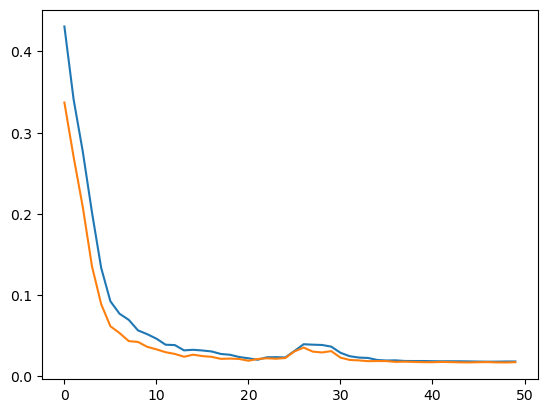

In [35]:
# code here
plt.plot(results['Loss'])
plt.plot(results['Val_Loss'])

In [36]:
acc = [i.detach().cpu() for i in results['Acc']]
val_acc = [i.detach().cpu() for i in results['Val_Acc']]

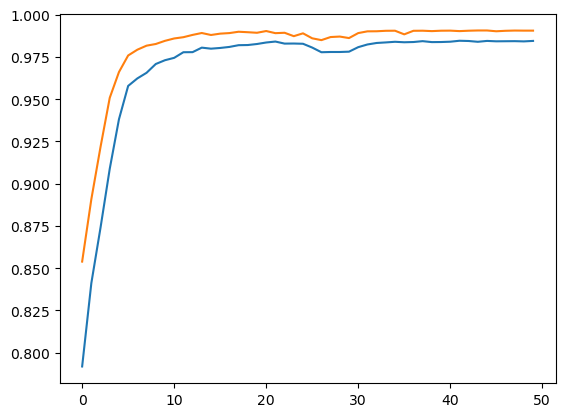

In [37]:
# code here
plt.plot(acc)
plt.plot(val_acc)

 - LSTM으로 학습을 수행합니다.
 - 클래스 LSTMModel을 생성하세요.
   - 임베딩 적용: 32차원
   - 싱글레이어 LSTM 적용
     - hidden_size=32
   - 출력 활성화 Sigmoid

In [47]:
# code here
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(1000, 32)
        self.lstm = nn.LSTM(32, 32, batch_first=True)
        self.output = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.embed(x)
        h_a, _ = self.lstm(out)
        out = self.output(h_a[:,-1,:])
        out = self.sigmoid(out)
        
        return out

 - 시드를 777로 설정하세요.

In [48]:
# code here
torch.manual_seed(777)

 - 모델 클래스를 이용하여 모델 인스턴스를 생성하세요.

In [49]:
# code here
model = LSTMModel().to(device)

- 모델의 summary를 출력하세요.

In [50]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
LSTMModel                                --
├─Embedding: 1-1                         32,000
├─LSTM: 1-2                              8,448
├─Linear: 1-3                            33
├─Sigmoid: 1-4                           --
Total params: 40,481
Trainable params: 40,481
Non-trainable params: 0

 - collate 함수를 다시 구현합니다.
 - collate 함수에서는 다음과 같은 작업을 수행해야 합니다.
   1. sentence to sequence
   2. pad_sequence

In [51]:
# 그대로 사용하세요.
from torch.nn.utils.rnn import pad_sequence
import numpy as np

def sent2seq(sentence):
    seq = [vocab[token] for token in tokenizer(sentence)]
    return seq

def collate_function(batch):
    label_list = []
    sentence_list = []
    first = True
    
    for (sentence, label) in batch:
        seq = torch.tensor(np.array(sent2seq(sentence)))
        sentence_list.append(seq)
        label_list.append(label)
    
    seq_list = pad_sequence(sentence_list, 
                                  padding_value=vocab['<pad>'], batch_first=True)
    label_list = torch.tensor(label_list)
    return torch.flip(seq_list, (1,)).to(torch.long), label_list

 - collate_function의 동작을 train_set으로 확인하세요.

In [52]:
# code here
collate_function(train_set)

(tensor([[  3,   3,   3,  ...,   9,   0, 568],
         [  3,   3,   3,  ...,   0,  14,   0],
         [  3,   3,   3,  ...,  96,   0,  57],
         ...,
         [  3,   3,   3,  ...,   0,   7,   4],
         [  3,   3,   3,  ...,   0,   0,  46],
         [  3,   3,   3,  ...,   0, 372, 227]]),
 tensor([0, 1, 1,  ..., 0, 0, 1]))

 - 테스트 배치 크기를 512개로 변경하세요.

In [53]:
# code here
train_loader= DataLoader(
    dataset = train_set,
    batch_size=256,
    drop_last=True,
    shuffle=True,
    collate_fn=collate_function) # 콜래트 함수 지정
                                 # 콜래트 함수는 batch 단위로 호출됨

test_loader= DataLoader(
    dataset = test_set,
    batch_size=256,
    collate_fn=collate_function)

 - 데이터에 적합한 loss와 optimizer를 선정하여 설정하세요.

In [54]:
# code here
loss = nn.BCELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

 - 학습 데이터와 검증 데이터를 이용하여 학습을 수행하세요.

In [55]:
from tqdm import notebook

# Code here
epochs = 50

results = {'Loss':[], 'Acc':[], 'Val_Loss':[], 'Val_Acc':[]}

progressbar = notebook.tqdm(range(epochs))

for epoch in progressbar:
    train_loss = 0
    test_loss = 0
    
    n_train_samples = len(train_loader.dataset)
    n_test_samples = len(test_loader.dataset)
    
    n_train_correct = 0
    n_test_correct = 0
    
    model.train()
    for x, y in train_loader:
        x = x.to(torch.long).to(device)
        y = y.to(torch.float32).to(device)
        
        h = model(x)
        cost = loss(h, y.view(-1, 1))
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    
        train_loss += cost.item()*x.shape[0]/n_train_samples
        n_train_correct += ((h>0.5).to(torch.int32)==y.view(-1, 1)).sum()
    results['Loss'].append(train_loss)
    results['Acc'].append(n_train_correct/n_train_samples)
    
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(torch.long).to(device)
            y = y.to(torch.float32).to(device)

            h = model(x)
            cost = loss(h, y.view(-1, 1))
            
            n_test_correct += ((h>0.5).to(torch.int32)==y.view(-1, 1)).sum()
            
            test_loss += cost.item()*x.shape[0]/n_test_samples
        results['Val_Loss'].append(test_loss)
        results['Val_Acc'].append(n_test_correct/n_test_samples)

    progressbar.set_postfix(
        loss=f'{results["Loss"][-1]:12.6f}',
        acc=f'{results["Acc"][-1]:12.6f}',
        val_loss=f'{results["Val_Loss"][-1]:12.6f}',
        val_acc=f'{results["Val_Acc"][-1]:12.6f}')

  0%|          | 0/50 [00:00<?, ?it/s]

- 결과 시각화

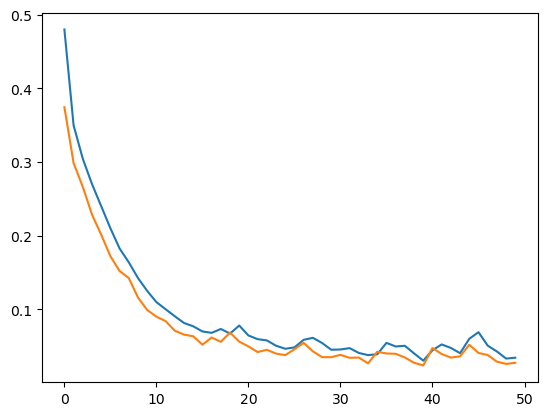

In [56]:
# code here
plt.plot(results['Loss'])
plt.plot(results['Val_Loss'])

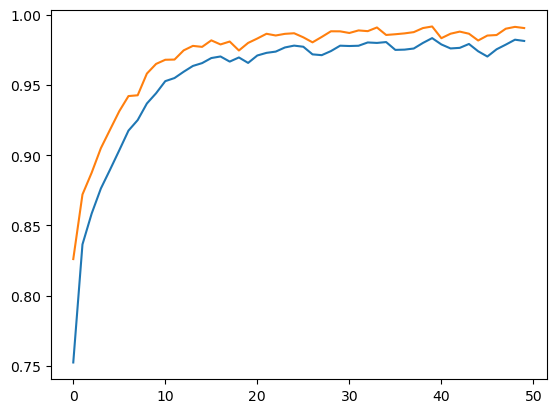

In [57]:
# code here
acc = [i.detach().cpu() for i in results['Acc']]
val_acc = [i.detach().cpu() for i in results['Val_Acc']]
plt.plot(acc)
plt.plot(val_acc)